In [2]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0
  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0
  gnutls             conda-forge/linux-64::gnutls-3.6.13-h85f3911_1
  lame               conda-forge/linux-64::lame-3.100-h7f98852_1001
  libiconv           conda-forge/linux-64::libiconv-1.16-h516909a_0
  nettle             conda-forge/linux-64::nettle-3.6-he412f7d_0
  openh264           conda-forge/linux-64::openh264-2.1.1-h780b84a_0
  torchaudio         pytorch/linux-64::torchaudio-0.11.0-py37_cu113
  torchvision        pytorch/linux-64::torchvision-0.12.0-py37_cu113

The following packages will be UPDATED:

  certifi                          2021.10.8-py37h89c1867_1 -->

In [4]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomGrayscale(),
     transforms.RandomPerspective(),
     transforms.ToTensor(),
     transforms.Normalize((0.50, 0.50, 0.50), (0.50, 0.50, 0.50))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


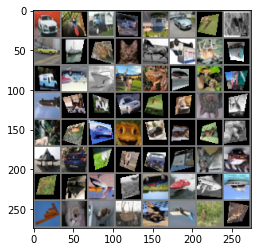

  car  bird truck   car   car   car  bird  deer   car  ship  frog   cat horse truck  deer truck truck   car  ship  deer  frog  ship   cat truck plane horse   dog   car   dog   cat   cat  deer  deer  deer   car  frog   car   cat horse   cat plane   car  bird   dog truck truck horse   car  deer plane  bird plane   car  ship  ship  ship plane   dog   dog  deer   dog plane  bird  deer


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')
      
        # Definebatch Normalization
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm1d(120)
        self.BN5 = nn.BatchNorm1d(84)

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.BN1(self.conv1_2(self.BN1(self.conv1_1(x))))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.BN2(self.conv2_2(self.BN2(self.conv2_1(x))))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.BN3(self.conv3_2(self.BN3(self.conv3_1(x))))))
        x = self.dropout3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.BN4(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.BN5(self.fc2(x)))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 100
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))
        
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0

    valid_loss = 0.0
    valid_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for inputs, labels in testloader:
        inputs,labels=inputs.to(device),labels.to(device)
        # Forward Pass
        outputs = net(inputs)
        # Find the Loss
        loss = criterion(outputs,labels)
        # Calculate Loss
        valid_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        valid_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Loss:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/100 	 Training Loss: 2.1756 	 Validation Loss: 2.281 	 Training Accuracy: 0.1823 	 Validation Loss:0.1514
Epoch 2/100 	 Training Loss: 1.8301 	 Validation Loss: 1.7275 	 Training Accuracy: 0.3123 	 Validation Loss:0.3574
Epoch 3/100 	 Training Loss: 1.6305 	 Validation Loss: 1.5762 	 Training Accuracy: 0.3949 	 Validation Loss:0.4095
Epoch 4/100 	 Training Loss: 1.5134 	 Validation Loss: 1.4675 	 Training Accuracy: 0.4426 	 Validation Loss:0.4582
Epoch 5/100 	 Training Loss: 1.4308 	 Validation Loss: 1.4142 	 Training Accuracy: 0.4749 	 Validation Loss:0.4806
Epoch 6/100 	 Training Loss: 1.3525 	 Validation Loss: 1.3391 	 Training Accuracy: 0.5056 	 Validation Loss:0.518
Epoch 7/100 	 Training Loss: 1.2946 	 Validation Loss: 1.2748 	 Training Accuracy: 0.5329 	 Validation Loss:0.5315
Epoch 8/100 	 Training Loss: 1.2462 	 Validation Loss: 1.2167 	 Training Accuracy: 0.5487 	 Validation Loss:0.5574
Epoch 9/100 	 Training Loss: 1.2029 	 Validation Loss: 1.2098 	 Training Accuracy:

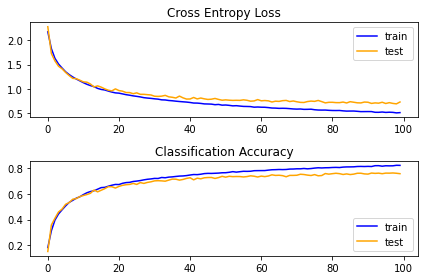

In [9]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
overall_acc = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 84.6 %
Accuracy for class car   is: 91.5 %
Accuracy for class bird  is: 72.3 %
Accuracy for class cat   is: 62.3 %
Accuracy for class deer  is: 73.3 %
Accuracy for class dog   is: 60.5 %
Accuracy for class frog  is: 76.1 %
Accuracy for class horse is: 80.6 %
Accuracy for class ship  is: 79.4 %
Accuracy for class truck is: 73.6 %
